# <font color=green>ADD-Net: An Effective Deep Learning Model for Early Detection of Alzheimer’s Diseases in MRI Scans</font>

### <font color=orange> Installs </font>

pip install tensorflow

pip install keras

pip install imblearn

pip install matplotlib

pip install seaborn

pip install scikit-learn

pip install tensorflow-addons

In [1]:
# Checa ambiente - se rodando local não usa o Google Drive
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if (IN_COLAB):
  !pip install tensorflow-addons
  from google.colab import drive
  drive.mount('/content/gdrive')

### <font color=orange> Importing Libraries </font>

In [2]:
import numpy as np
import random

#   Plotting
import seaborn as sns
import matplotlib.pyplot as plt


#   DataGenerator to read images and rescale images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import tensorflow_addons as tfa

#   count each class samples
from collections import Counter

#   callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau

#   evaluate precison recall and f1-score of each class of model
from sklearn.metrics import classification_report
#   Show performance of a classification model
from sklearn.metrics import confusion_matrix

#   Different layers
from keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Softmax

# split dataset to train, validation and test set
from sklearn.model_selection import train_test_split

#   callbacks
from keras import callbacks

#   SMOTETomek from imblance library
from imblearn.combine import SMOTETomek

#   Optimizer
from tensorflow.keras.optimizers import SGD

from sklearn.metrics import roc_curve, auc
from itertools import cycle

c:\Users\fabio.grassiotto\Miniconda3\envs\AlzClas\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### <font color=orange> Define directory of dataset & Classes names </font>

In [3]:
## Set Path Here before running the code
if (IN_COLAB):
    data_path1 = '/content/gdrive/MyDrive/IA901A_Projeto/data/interim/OASIS_slices2_flat_single_3classes'
else:
    data_path1 = '../../../../data/interim/OASIS_slices2_flat_single_3classes'

##  Name of classes
CLASSES = ['MildDemented', 'NonDemented', 'VeryMildDemented']

### <font color=orange> Load Images, Rescale Images, and separate from data generator & Label One Hot encoding </font>

In [4]:
X, y = [], []

## Images rescaling
datagen = ImageDataGenerator(rescale=1.0/255.0)

#   Load images by resizing and shuffling randomly
train_dataset = datagen.flow_from_directory(data_path1, target_size=(176, 208),batch_size=4344, shuffle=True)

### Separate Dataset from Data Generator
X, y = train_dataset.next()

Found 414 images belonging to 3 classes.


In [5]:
samples_before = len(X)
print("Images shape :\t", X.shape)
print("Labels shape :\t", y.shape)

Images shape :	 (414, 176, 208, 3)
Labels shape :	 (414, 3)


In [6]:
#   Number of samples in classes
print("Number of samples in each class:\t", sorted(Counter(np.argmax(y, axis=1)).items()))

#   class labels as per indices
print("Classes Names according to index:\t", train_dataset.class_indices)

Number of samples in each class:	 [(0, 28), (1, 316), (2, 70)]
Classes Names according to index:	 {'MildDemented': 0, 'NonDemented': 1, 'VeryMildDemented': 2}


### <font color=orange> Show some random samples from the original dataset </font>

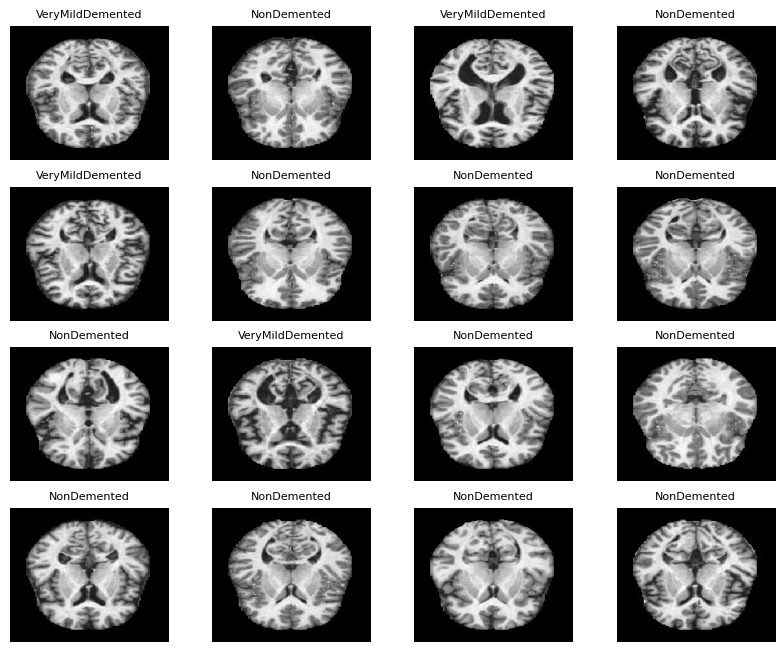

In [7]:
#   show some samples from the dataset randomly
fig = plt.figure(figsize=(10,8))

rows = 4
columns = 4

for i in range(rows * columns):
    fig.add_subplot(rows, columns, i+1)
    num = random.randint(0, len(X)-1 )
    plt.imshow(X[num])
    plt.axis('off')
    plt.title(CLASSES[(np.argmax(y[num]))], fontsize=8)
plt.axis('off')
plt.show()

### <font color=orange> Apply SMOTETomek Algorithm to balance the dataset </font>

In [8]:
def SmoteTomek(X, y):

    #   reshaping the images to 1D
    X = X.reshape(-1, 176 * 208 * 3)

    #   Oversampling method to remove imbalance class problem
    X, y = SMOTETomek().fit_resample(X, y)

    #   reshape images to images size of 208, 176, 3
    X = X.reshape(-1, 176, 208, 3)

    samples_after = len(X)
    print("Number of samples after SMOTETomek :\t", sorted(Counter(np.argmax(y, axis=1)).items()))

    return X, y

### <font color=orange> Show some random samples from the Generated dataset </font>

In [9]:
#fig = plt.figure(figsize=(10,8))

#rows = 4
#columns = 4

#for i in range(rows * columns):
#    fig.add_subplot(rows, columns, i+1)
#    num = random.randint(samples_before, samples_after - 1 )
#    plt.imshow(X[num])
#    plt.axis('off')
#    plt.title(CLASSES[(np.argmax(y[num]))], fontsize=8)
#plt.axis('off')
#plt.show()

### <font color=orange> Splitting dataset for Training, Validation & Testing </font>

In [10]:
#   20% split to validation and 80% split to train set
X_train, x_val, y_train, y_val = train_test_split(X,y, test_size = 0.2)

#   20% split to test from 80% of train and 60% remains in train set
X_train, x_test, y_train, y_test = train_test_split(X_train,y_train, test_size = 0.2)

# Number of samples after train test split
print("Number of samples after splitting into Training, validation & test set\n")

print("Train     \t",sorted(Counter(np.argmax(y_train, axis=1)).items()))
print("Validation\t",sorted(Counter(np.argmax(y_val, axis=1)).items()))
print("Test      \t",sorted(Counter(np.argmax(y_test, axis=1)).items()))

# Apply SmotekTomek (training only)

X_train, y_train = SmoteTomek(X_train, y_train)

Number of samples after splitting into Training, validation & test set

Train     	 [(0, 15), (1, 201), (2, 48)]
Validation	 [(0, 6), (1, 61), (2, 16)]
Test      	 [(0, 7), (1, 54), (2, 6)]
Number of samples after SMOTETomek :	 [(0, 201), (1, 201), (2, 201)]


In [11]:
#   to free memory we don't need this one as we split our data
del X, y

### <font color=orange> Model Architecture </font>

In [12]:
from keras.initializers import GlorotUniformV2
init = GlorotUniformV2

model = Sequential()

model.add(Input(shape=(176, 208, 3)))

model.add(Convolution2D(16, 5, kernel_initializer=init))
model.add(ReLU())
model.add(AveragePooling2D(pool_size=(2,2)))

model.add(Convolution2D(32, 5, kernel_initializer=init))
model.add(ReLU())
model.add(AveragePooling2D(pool_size=(2,2)))

model.add(Convolution2D(64, 5, kernel_initializer=init))
model.add(ReLU())
model.add(AveragePooling2D(pool_size=(2,2)))

model.add(Convolution2D(128, 5, kernel_initializer=init))
model.add(ReLU())
model.add(AveragePooling2D(pool_size=(2,2)))


model.add(Dropout(0.01))

model.add(Flatten())

model.add(Dense(256, kernel_initializer=init))
model.add(ReLU())
model.add(Dropout(0.03))

model.add(Dense(3, kernel_initializer=init))
model.add(Softmax())

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 172, 204, 16)      1216      
                                                                 
 re_lu (ReLU)                (None, 172, 204, 16)      0         
                                                                 
 average_pooling2d (AverageP  (None, 86, 102, 16)      0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 82, 98, 32)        12832     
                                                                 
 re_lu_1 (ReLU)              (None, 82, 98, 32)        0         
                                                                 
 average_pooling2d_1 (Averag  (None, 41, 49, 32)       0         
 ePooling2D)                                            

### <font color=orange> Compiling the Model </font>

In [13]:
### Model Compilation
model.compile(
    optimizer=SGD(learning_rate=0.01),
    loss = tf.keras.losses.CategoricalCrossentropy(name='loss'),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='acc'),
        tf.keras.metrics.AUC(name='auc'),
        tfa.metrics.F1Score(num_classes=3),
        tf.metrics.Precision(name="precision"),
        tf.metrics.Recall(name="recall") ])


### <font color=orange> Defining CALLBACKS to reduce Learning Rate </font>

In [14]:
# callbacks used in model to perform well
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=2)

CALLBACKS = [rop_callback]

### <font color=orange> Training of the Model </font>

In [15]:
print(X_train.shape)

(603, 176, 208, 3)


In [16]:
tf.debugging.disable_traceback_filtering()

#   declare to run on small gpu create batch sizes of images
valAug = ImageDataGenerator()

#   defining batch size
batch_size = 8

history = model.fit(valAug.flow(X_train, y_train, batch_size=batch_size, shuffle = True),
steps_per_epoch=len(X_train) // batch_size,
validation_data=valAug.flow(x_val, y_val, batch_size=batch_size, shuffle = True),
validation_steps=len(x_test) // batch_size,
epochs= 40,
batch_size=batch_size,
callbacks = CALLBACKS
)

Epoch 1/40
75/75 [==============================] - 18s 207ms/step - loss: 1.0958 - acc: 0.3496 - auc: 0.5350 - f1_score: 0.3474 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.1129 - val_acc: 0.1562 - val_auc: 0.3021 - val_f1_score: 0.1797 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0100
Epoch 2/40
75/75 [==============================] - 15s 201ms/step - loss: 1.0821 - acc: 0.3966 - auc: 0.5897 - f1_score: 0.3929 - precision: 0.4444 - recall: 0.0067 - val_loss: 1.0209 - val_acc: 0.7344 - val_auc: 0.8806 - val_f1_score: 0.4432 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0100
Epoch 3/40
75/75 [==============================] - 15s 204ms/step - loss: 1.0434 - acc: 0.4454 - auc: 0.6429 - f1_score: 0.4416 - precision: 0.6222 - recall: 0.0471 - val_loss: 1.2274 - val_acc: 0.0938 - val_auc: 0.3178 - val_f1_score: 0.0663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0100
Epoch 4/40
75/75 [==============================] - 15s 205ms/

In [17]:
import os

## Set Path Here before running the code
#main_dir =  '../../../data/interim/OASIS_slices2_flat_single_3classes'

##  Name of classes
#classes = ['MildDemented', 'NonDemented', 'VeryMildDemented']

# Generators
#train_generator = datagen.flow_from_directory((main_dir+'/train'), target_size=(176, 208), batch_size=32, shuffle=True)
#val_generator = datagen.flow_from_directory((main_dir+'/val'), target_size=(176, 208), batch_size=32, shuffle=True)
#test_generator = datagen.flow_from_directory((main_dir+'/test'), target_size=(176, 208), batch_size=32, shuffle=False)

In [18]:
# Training the model using the training and validation generators
#history = model.fit(
#    train_generator,
#    steps_per_epoch=len(train_generator),
#    validation_data=val_generator,
#    validation_steps=len(val_generator),
#    epochs= 40,
#    callbacks = CALLBACKS
#)

### <font color=orange> Hyperparameter tuning </font>

### <font color=orange> Evaluation of Model with the Test data </font>

In [19]:
### Evaluate Model
test_scores = model.evaluate(x_test, y_test, batch_size = 32)


print("\n\nTesting Loss : \t\t {0:0.6f}".format(test_scores[0] ))
print("Testing Accuracy : \t {0:0.6f} %".format(test_scores[1] * 100))
print("Testing AC : \t\t {0:0.6f} %".format(test_scores[2] * 100))
print("Testing F1-Score : \t {0:0.6f} %".format(((test_scores[3][0] + test_scores[3][1] + test_scores[3][2] )/3) * 100))
print("Testing Precision : \t {0:0.6f} %".format(test_scores[4] * 100))
print("Testing Recall : \t {0:0.6f} %".format(test_scores[5] * 100))

3/3 [==============================] - 1s 174ms/step - loss: 0.5268 - acc: 0.7313 - auc: 0.9324 - f1_score: 0.5029 - precision: 0.7656 - recall: 0.7313


Testing Loss : 		 0.526756
Testing Accuracy : 	 73.134327 %
Testing AC : 		 93.244600 %
Testing F1-Score : 	 50.285717 %
Testing Precision : 	 76.562500 %
Testing Recall : 	 73.134327 %


### <font color=orange> Model Training graphs </font>
- Accuracy
- Loss
- AUC
- Precision
- Recall
- F1-Score

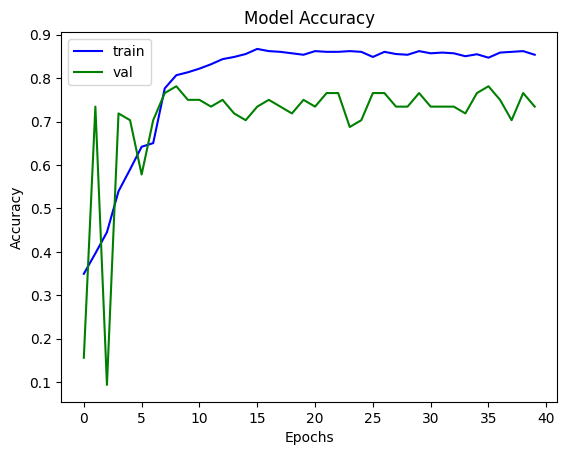

In [20]:
plt.plot(history.history['acc'], 'b')
plt.plot(history.history['val_acc'], 'g')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["train", "val"])
plt.show()

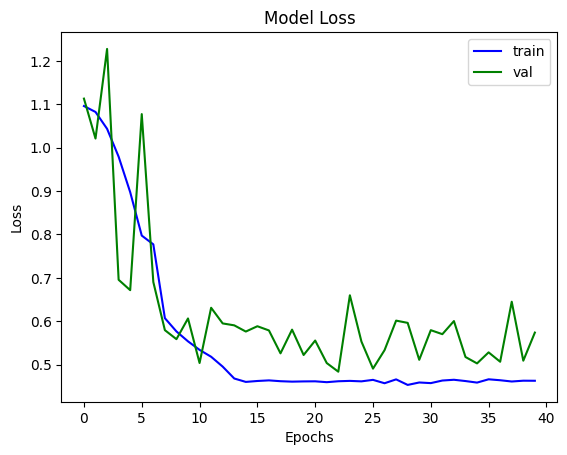

In [21]:
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'g')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["train", "val"])
plt.show()

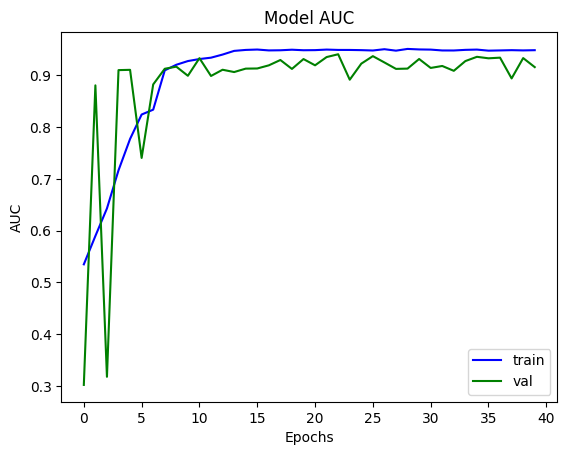

In [22]:
plt.plot(history.history['auc'], 'b')
plt.plot(history.history['val_auc'], 'g')
plt.title("Model AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend(["train", "val"])
plt.show()

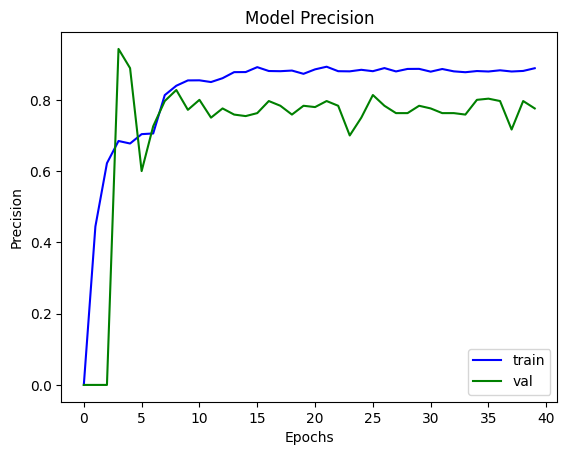

In [23]:
plt.plot(history.history['precision'], 'b')
plt.plot(history.history['val_precision'], 'g')
plt.title("Model Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend(["train", "val"])
plt.show()

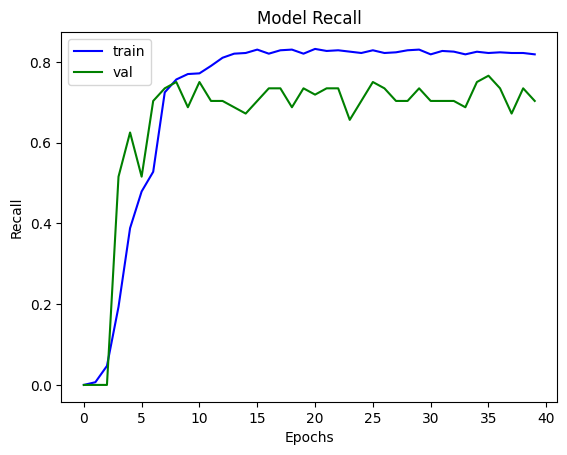

In [24]:
plt.plot(history.history['recall'], 'b')
plt.plot(history.history['val_recall'], 'g')
plt.title("Model Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend(["train", "val"])
plt.show()

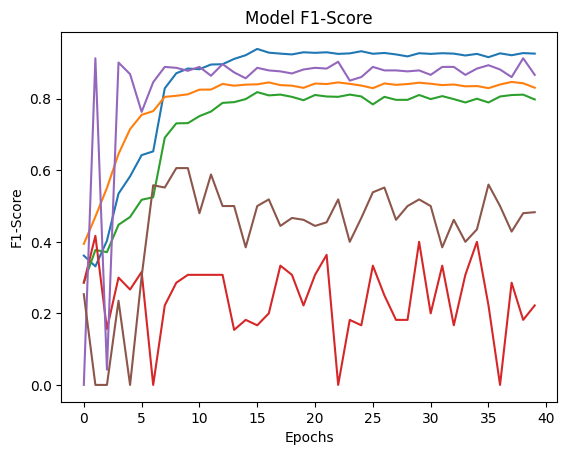

In [25]:
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title("Model F1-Score")
plt.xlabel("Epochs")
plt.ylabel("F1-Score")
plt.show()

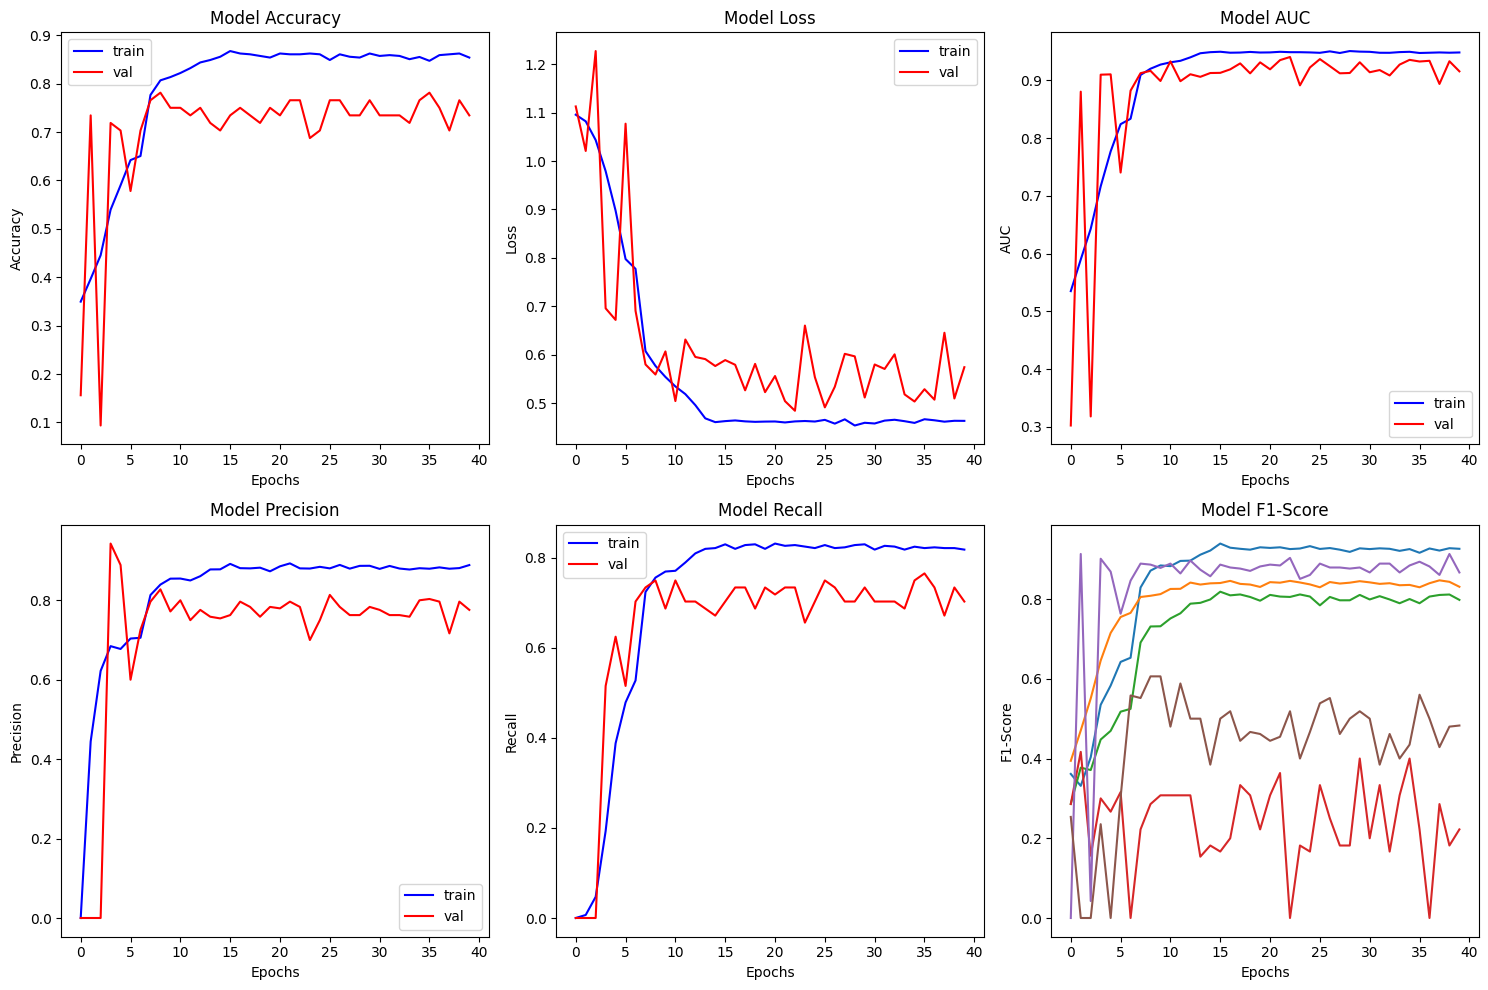

In [26]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot Accuracy
axes[0, 0].plot(history.history['acc'], 'b')
axes[0, 0].plot(history.history['val_acc'], 'r')
axes[0, 0].set_title("Model Accuracy")
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].legend(["train", "val"])

# Plot Loss
axes[0, 1].plot(history.history['loss'], 'b')
axes[0, 1].plot(history.history['val_loss'], 'r')
axes[0, 1].set_title("Model Loss")
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend(["train", "val"])

# Plot AUC
axes[0, 2].plot(history.history['auc'], 'b')
axes[0, 2].plot(history.history['val_auc'], 'r')
axes[0, 2].set_title("Model AUC")
axes[0, 2].set_xlabel("Epochs")
axes[0, 2].set_ylabel("AUC")
axes[0, 2].legend(["train", "val"])

# Plot Precision
axes[1, 0].plot(history.history['precision'], 'b')
axes[1, 0].plot(history.history['val_precision'], 'r')
axes[1, 0].set_title("Model Precision")
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].set_ylabel("Precision")
axes[1, 0].legend(["train", "val"])

# Plot Recall
axes[1, 1].plot(history.history['recall'], 'b')
axes[1, 1].plot(history.history['val_recall'], 'r')
axes[1, 1].set_title("Model Recall")
axes[1, 1].set_xlabel("Epochs")
axes[1, 1].set_ylabel("Recall")
axes[1, 1].legend(["train", "val"])

# Plot F1-Score
axes[1, 2].plot(history.history['f1_score'])
axes[1, 2].plot(history.history['val_f1_score'])
axes[1, 2].set_title("Model F1-Score")
axes[1, 2].set_xlabel("Epochs")
axes[1, 2].set_ylabel("F1-Score")

# Ensure the plot is displayed properly with all the subplots visible.
fig.tight_layout()

plt.show()


### <font color=orange> Test set Evaluation </font>
- Classification Report
- Confusion Matrix
- ROC Curve
- Extension ROC Multiclass

In [27]:
pred_labels = model.predict(x_test, batch_size=32)

def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(y_test, pred_labels, target_names=CLASSES))


3/3 [==============================] - 1s 85ms/step
                  precision    recall  f1-score   support

    MildDemented       0.43      0.43      0.43         7
     NonDemented       0.96      0.81      0.88        54
VeryMildDemented       0.14      0.33      0.20         6

       micro avg       0.73      0.73      0.73        67
       macro avg       0.51      0.53      0.50        67
    weighted avg       0.83      0.73      0.77        67
     samples avg       0.73      0.73      0.73        67



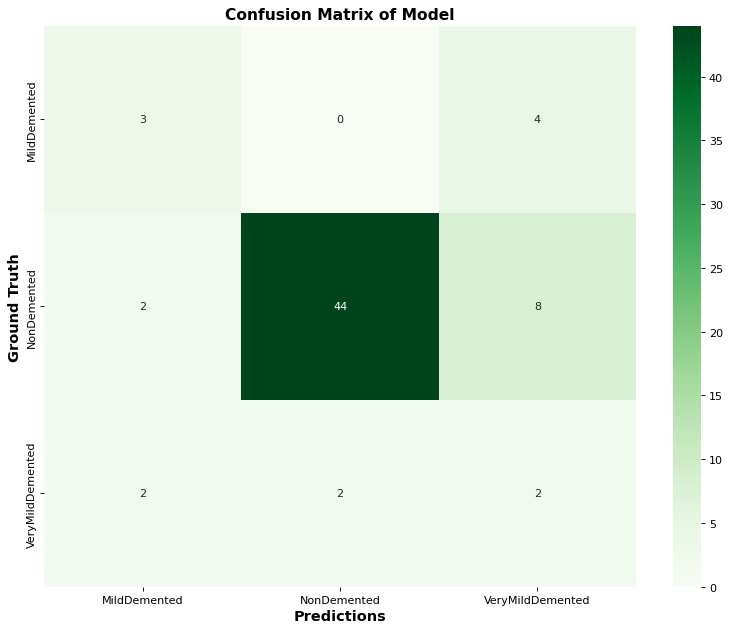

In [28]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(y_test, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES, yticklabels=CLASSES)

plt.title('Confusion Matrix of Model', fontweight='bold', fontsize=14.0)
plt.xlabel('Predictions', fontweight='bold', fontsize=13)
plt.ylabel('Ground Truth', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show(ax)

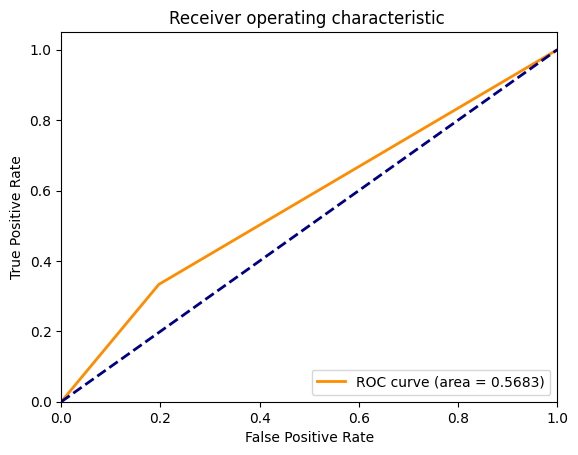

In [29]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_labels[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_labels.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.4f)" % roc_auc[2])

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic ")
plt.legend(loc="lower right")
plt.show()

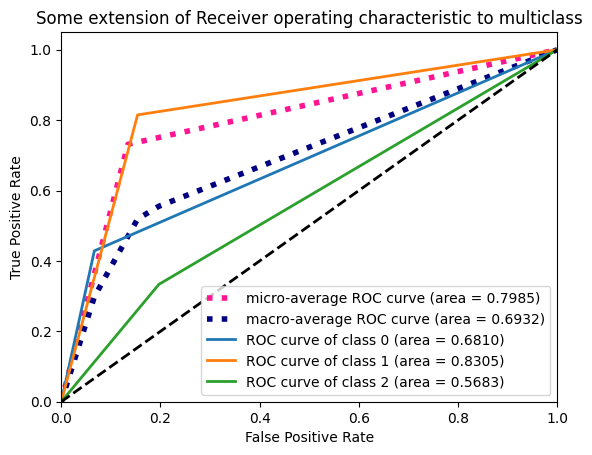

In [30]:
n_classes = 3
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.4f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.4f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.4f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

### <font color=orange> Saving Model for Future Use </font>

In [31]:
#    To save the model in the current directory
model.save(".\\ADDmodel.h5")